In [1]:
import logging
import sys
import os
from os import getenv
from os.path import abspath, basename, split,dirname
import tarfile
from shutil import copyfile
import random, glob
from skimage.util import random_noise
from skimage.transform import rotate
import time
import numpy as np
import math
import gc

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

from tensorflow.keras.applications import EfficientNetB0,EfficientNetB3, EfficientNetB2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras import layers
from tensorflow import keras
#from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [17]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 10
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

num_classes = 28
image_size =224
size = (image_size, image_size)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Ramdhan/Unearth/visual-grain-analysis/data/public/train",
    image_size=size,
    batch_size=BATCH_SIZE,
    interpolation='nearest'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Ramdhan/Unearth/visual-grain-analysis/data/public/val",
    image_size=size,
    batch_size=BATCH_SIZE,
    interpolation='nearest'
)

Found 19182 files belonging to 28 classes.
Found 7648 files belonging to 28 classes.


In [3]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image

def rotate_image(image):
    degree = tf.random.normal([])*360
    image = tfa.image.rotate(image, degree * math.pi / 180)
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    #image = flip_random_crop(image)
    #image = random_apply(color_jitter, image, p=0.8)
    #image = random_apply(color_drop, image, p=0.2)
    image = random_apply(rotate_image, image, p=0.8)
    return image

In [4]:
x_train = []
for element in train_ds.as_numpy_iterator(): 
    x_train.append(element[0]) 
x_train = np.concatenate(x_train, axis=0)
num_training_samples = len(x_train)

In [5]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

del x_train
gc.collect()

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

C:\Users\Owner\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\autograph\impl\api.py:493: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  return py_builtins.overload_of(f)(*args)


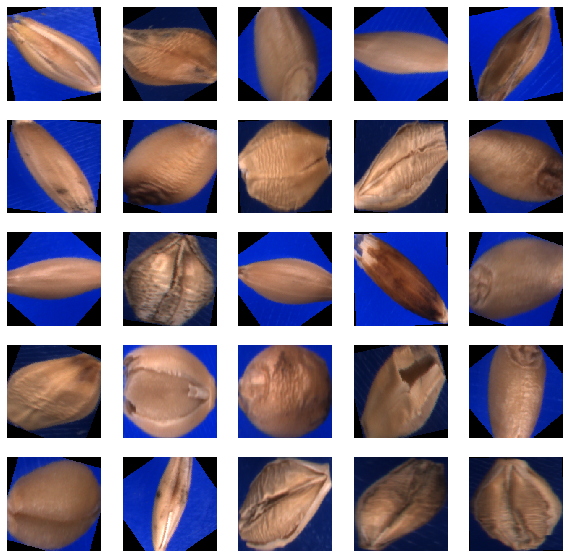

In [6]:
# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()


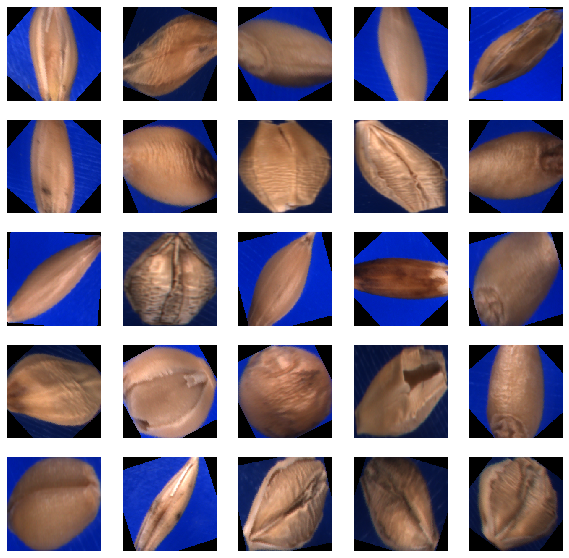

In [7]:
# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [8]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1


def get_encoder():
    # Input and backbone.
    inputs = layers.Input((224,224, 3))
    x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

In [9]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

In [10]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

Epoch 1/10
600/600 [==============================] - 461s 769ms/step - loss: -0.9554
Epoch 2/10
600/600 [==============================] - 457s 762ms/step - loss: -0.9785
Epoch 3/10
600/600 [==============================] - 467s 778ms/step - loss: -0.9903
Epoch 4/10
600/600 [==============================] - 456s 760ms/step - loss: -0.9939
Epoch 5/10
600/600 [==============================] - 456s 760ms/step - loss: -0.9947
Epoch 6/10
600/600 [==============================] - 456s 761ms/step - loss: -0.9950
Epoch 7/10
600/600 [==============================] - 455s 759ms/step - loss: -0.9951
Epoch 8/10
600/600 [==============================] - 454s 757ms/step - loss: -0.9952
Epoch 9/10
600/600 [==============================] - 455s 758ms/step - loss: -0.9952
Epoch 10/10
600/600 [==============================] - 455s 758ms/step - loss: -0.9952


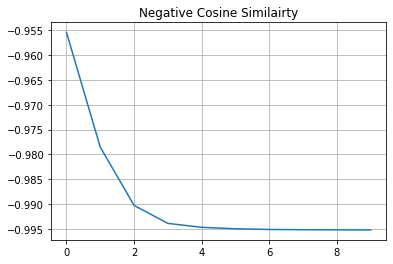

In [11]:
# Create a cosine decay learning scheduler.
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.03, decay_steps=steps)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds, epochs=EPOCHS, 
                      callbacks=[early_stopping]
                     )

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [18]:
x_train = []
y_train = []
x_test = []
y_test = []
for element in train_ds.as_numpy_iterator(): 
    x_train.append(element[0]) 
x_train = np.concatenate(x_train, axis=0)

for element in train_ds.as_numpy_iterator(): 
    y_train.append(element[1]) 
y_train = np.concatenate(y_train, axis=0)

for element in val_ds.as_numpy_iterator(): 
    x_test.append(element[0]) 
x_test = np.concatenate(x_test, axis=0)

for element in val_ds.as_numpy_iterator(): 
    y_test.append(element[1]) 
y_test = np.concatenate(y_test, axis=0)

In [19]:
def acc_grain(y_true, y_pred):
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)
    sample_weight = np.hstack((np.where(y_true_class.numpy().reshape(-1,1)==7,True,False),np.where(y_true_class.numpy().reshape(-1,1)==24,True,False),np.where(y_true_class.numpy().reshape(-1,1)==13,True,False)))
    sample_weight = np.any(sample_weight,axis=1)
    sample_weight = np.where(sample_weight,8.94,1.0)
    return K.constant(accuracy_score(y_true_class,y_pred_class,sample_weight=sample_weight))

In [20]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    #.map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet20.
backbone = tf.keras.Model(simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output)

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = backbone(inputs, training=False)
outputs = layers.Dense(num_classes, activation="softmax")(x)
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
600/600 [==============================] - 73s 122ms/step - loss: 3.9485 - accuracy: 0.2549 - val_loss: 3.9072 - val_accuracy: 0.2599
Epoch 2/10
600/600 [==============================] - 73s 122ms/step - loss: 3.9140 - accuracy: 0.2589 - val_loss: 3.9102 - val_accuracy: 0.2165
Epoch 3/10
600/600 [==============================] - 73s 122ms/step - loss: 3.9137 - accuracy: 0.2560 - val_loss: 3.9075 - val_accuracy: 0.2478
Epoch 4/10
600/600 [==============================] - 73s 121ms/step - loss: 3.9126 - accuracy: 0.2581 - val_loss: 3.9068 - val_accuracy: 0.2584
Epoch 5/10
600/600 [==============================] - 72s 121ms/step - loss: 3.9118 - accuracy: 0.2597 - val_loss: 3.9065 - val_accuracy: 0.2601
Epoch 6/10
600/600 [==============================] - 72s 121ms/step - loss: 3.9112 - accuracy: 0.2603 - val_loss: 3.9060 - val_accuracy: 0.2593
Epoch 7/10
600/600 [==============================] - 73s 122ms/step - loss: 3.9108 - accuracy: 0.2599 - val_loss: 3.9059 - val_ac

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(inputs)
del inputs

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
import matplotlib.pyplot as plt
def input_preprocess_train(image, size):
    image = tf.image.resize(image, size)
    return image

size = (image_size,image_size)

for x_train, y_train in train_ds.take(1):
    print()
    
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes,activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def acc_grain(y_true, y_pred):
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)
    sample_weight = np.hstack((np.where(y_true_class.numpy().reshape(-1,1)==7,True,False),np.where(y_true_class.numpy().reshape(-1,1)==24,True,False),np.where(y_true_class.numpy().reshape(-1,1)==13,True,False)))
    sample_weight = np.any(sample_weight,axis=1)
    sample_weight = np.where(sample_weight,8.94,1.0)
    return K.constant(accuracy_score(y_true_class,y_pred_class,sample_weight=sample_weight))

def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tensorflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=[acc_grain],run_eagerly=True
    )
    
    filename = 'checkpoints'
    checkpoint = ModelCheckpoint(filename, monitor='val_acc_grain', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    lr_schedule= get_cosine_schedule_with_warmup(lr=0.001, num_warmup_steps=4, num_training_steps=num_epochs)
    weights = dict(zip([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], [1,1,1,1,1,1,1,8.94,1,1,1,1,1,8.94,1,1,1,1,1,1,1,1,1,1,8.94,1,1,1]))
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_epochs,
        callbacks=[checkpoint,lr_schedule],
        class_weight=weights,verbose=1
    )
                        
    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

In [ ]:
tf.__version__

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation iou_score values
plt.figure(figsize=(30, 20))
plt.subplot(121)
plt.plot(history.history['acc_grain'])
plt.plot(history.history['val_acc_grain'])
plt.title('Model acc_score')
plt.ylabel('acc_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import pandas as pd
import zipfile
import csv

start = time.time()

def load_class_list(class_list_file):
    class_list = []
    with open(class_list_file, 'r') as csvfile:
        file_reader = csv.reader(csvfile)
        for row in file_reader:
            class_list.append(row[0])
    class_list.sort()
    return class_list

class_list = load_class_list('class_list.txt')

IMG_SIZE=224
LBL = dict(zip(class_list, range(28)))

cls_map = dict(zip(LBL.values(),LBL.keys()))

def init_dir(pth):
    if os.path.exists(pth):
        shutil.rmtree(pth)
    os.mkdir(pth)

logger.info("loading the model")
model = model_fn(args['model_dir'])
logger.info("Reading the test set")

res = []
for fn in glob.iglob(args['data_dir'] + 'val/**/*.png', recursive=True):
    file_name = os.path.basename(fn)
    path = os.path.abspath(fn)
    folder = os.path.split(os.path.dirname(path))[1]
    if len(file_name.split("-")) > 2:  # ignore master image with may grains, raw image names are in guid format
        im = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(im)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        pred = model.predict(img_preprocessed)
        top3 = (-pred[0]).argsort()[:3]
        res.append({'file_name': file_name, 'path': path, 'cls': folder, 'prediction':top3[0],  'proba_1':pred[0][top3[0]], 'prediction2':top3[1], 'proba_2':pred[0][top3[1]],  'prediction3':top3[2], 'proba_3':pred[0][top3[2]]})

df = pd.DataFrame(res)
df['prediction'] = df.prediction.map(cls_map)
df['prediction2'] = df.prediction2.map(cls_map)
df['prediction3'] = df.prediction3.map(cls_map)

from sklearn.metrics import accuracy_score

def w(x):
    if "_SOUND" in x:
        return 8.94 # weighting  Healthy grains more important than defective grains
    return 1

def scoring_fn(df):
    """
    Weighted Accuracy Metric 90% Healthy grains, 10% unhealthy grains
    """
    df['weight'] = df.cls.apply(w)
    return accuracy_score(df.cls,df.prediction,sample_weight=df.weight)

logger.info(f"predictions have shape of {df.shape}")

score = scoring_fn(df)
print ("Accuracy Score:" + str(score))
# write to the output location

print('Duration Run',(time.time()-start)/3600,' hours')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df['cls'], df['prediction']))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
ticks=np.linspace(0, 27,num=28)
plt.figure(figsize=(15,15))
plt.imshow(confusion_matrix(df['cls'], df['prediction'],normalize='true'), interpolation='none')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)
plt.show()

In [ ]:
from keras_preprocessing import image

In [ ]:
NUM_CLASSES=28
model = build_model(num_classes=NUM_CLASSES)
model.fit?

In [ ]:
image.random_rotation(90)

In [ ]:
 rotation_range=args.rotation,
      shear_range=args.shear,
      zoom_range=args.zoom,
      horizontal_flip=args.h_flip,
      vertical_flip=args.v_flip